<a href="https://colab.research.google.com/github/Panashe1812/Masters-Project/blob/main/SHAPley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install pytest

     -------------------------------------- 298.2/298.2 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 98.7/98.7 kB 5.5 MB/s eta 0:00:00
  Using cached iniconfig-1.1.1-py2.py3-none-any.whl (5.0 kB)


In [ ]:
from __future__ import print_function, division
import os
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
import pandas as pd
from skimage import io, transform
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

!pip install IPython
from IPython.core.debugger import set_trace
!pip install scikit-learn
from sklearn.preprocessing import OneHotEncoder

import time
import os
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
# Check for GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [ ]:
#custom Dataset class to load the custom data
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        #if torch.is_tensor(index):
            #idx = idx.tolist()
            
        
        
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        
        #convert str labels to int labels
        class_map = {'Latino_Hispanic': 0,
             'East Asian': 1,
             'Indian': 2,
             'Middle Eastern': 3,
             'Black': 4,
             'Southeast Asian': 5,
             'White': 6
             }
        
        label = self.annotations.iloc[index, 3] # returns a tuple of strings
        label =class_map[label]
        #label= OneHotEncoder(label)
        
        #label = label.applylambda label: list(map(int, label)))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [ ]:
from torchvision import transforms as T
vis_augs = transforms.Compose([
                    T.ToPILImage(),
                    T.Resize((224,224)),
                    T.ToTensor(),
             
                     
    ]
                    )

In [ ]:
# Load Data
train_data = CustomDataset(
    csv_file="fairface_label_train.csv",
    root_dir="train/",
    transform=vis_augs,
)

# Load Data
test_data = CustomDataset(
    csv_file="fairface_label_val.csv",
    root_dir="val/",
    transform=vis_augs,
)

In [ ]:
#batch_size = 127
batch_size = 32

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
test_loader = DataLoader(test_data,batch_size=batch_size, shuffle=True)

In [ ]:
import shap

In [ ]:
model = models.vgg16(pretrained=True)
#model = models.AlexNet(pretrained = True)
#replace the last linear layer from classifier
last_layer = nn.Linear(4096,7)
model.classifier[6] = last_layer


In [ ]:
import torch.nn.functional as F

In [ ]:
# Model class must be defined somewhere
PATH = './vgg16_50_epochs.pth'

model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
batch = next(iter(test_loader))
images, lbl = batch


In [ ]:
mean = [0.485, 0.456, 0.406]

In [ ]:
background = images[8:20].to(device)
test_images = images[7:14].to(device)

In [ ]:
x = F.normalize(test_images, dim = 0)

In [ ]:
y= F.normalize(background, dim = 0)

In [ ]:
e = shap.DeepExplainer(model, x)
shap_values = e.shap_values(y)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(y.cpu().numpy(), 1, -1), 1, 2)

In [ ]:
v =shap_numpy[0]
y=test_numpy[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

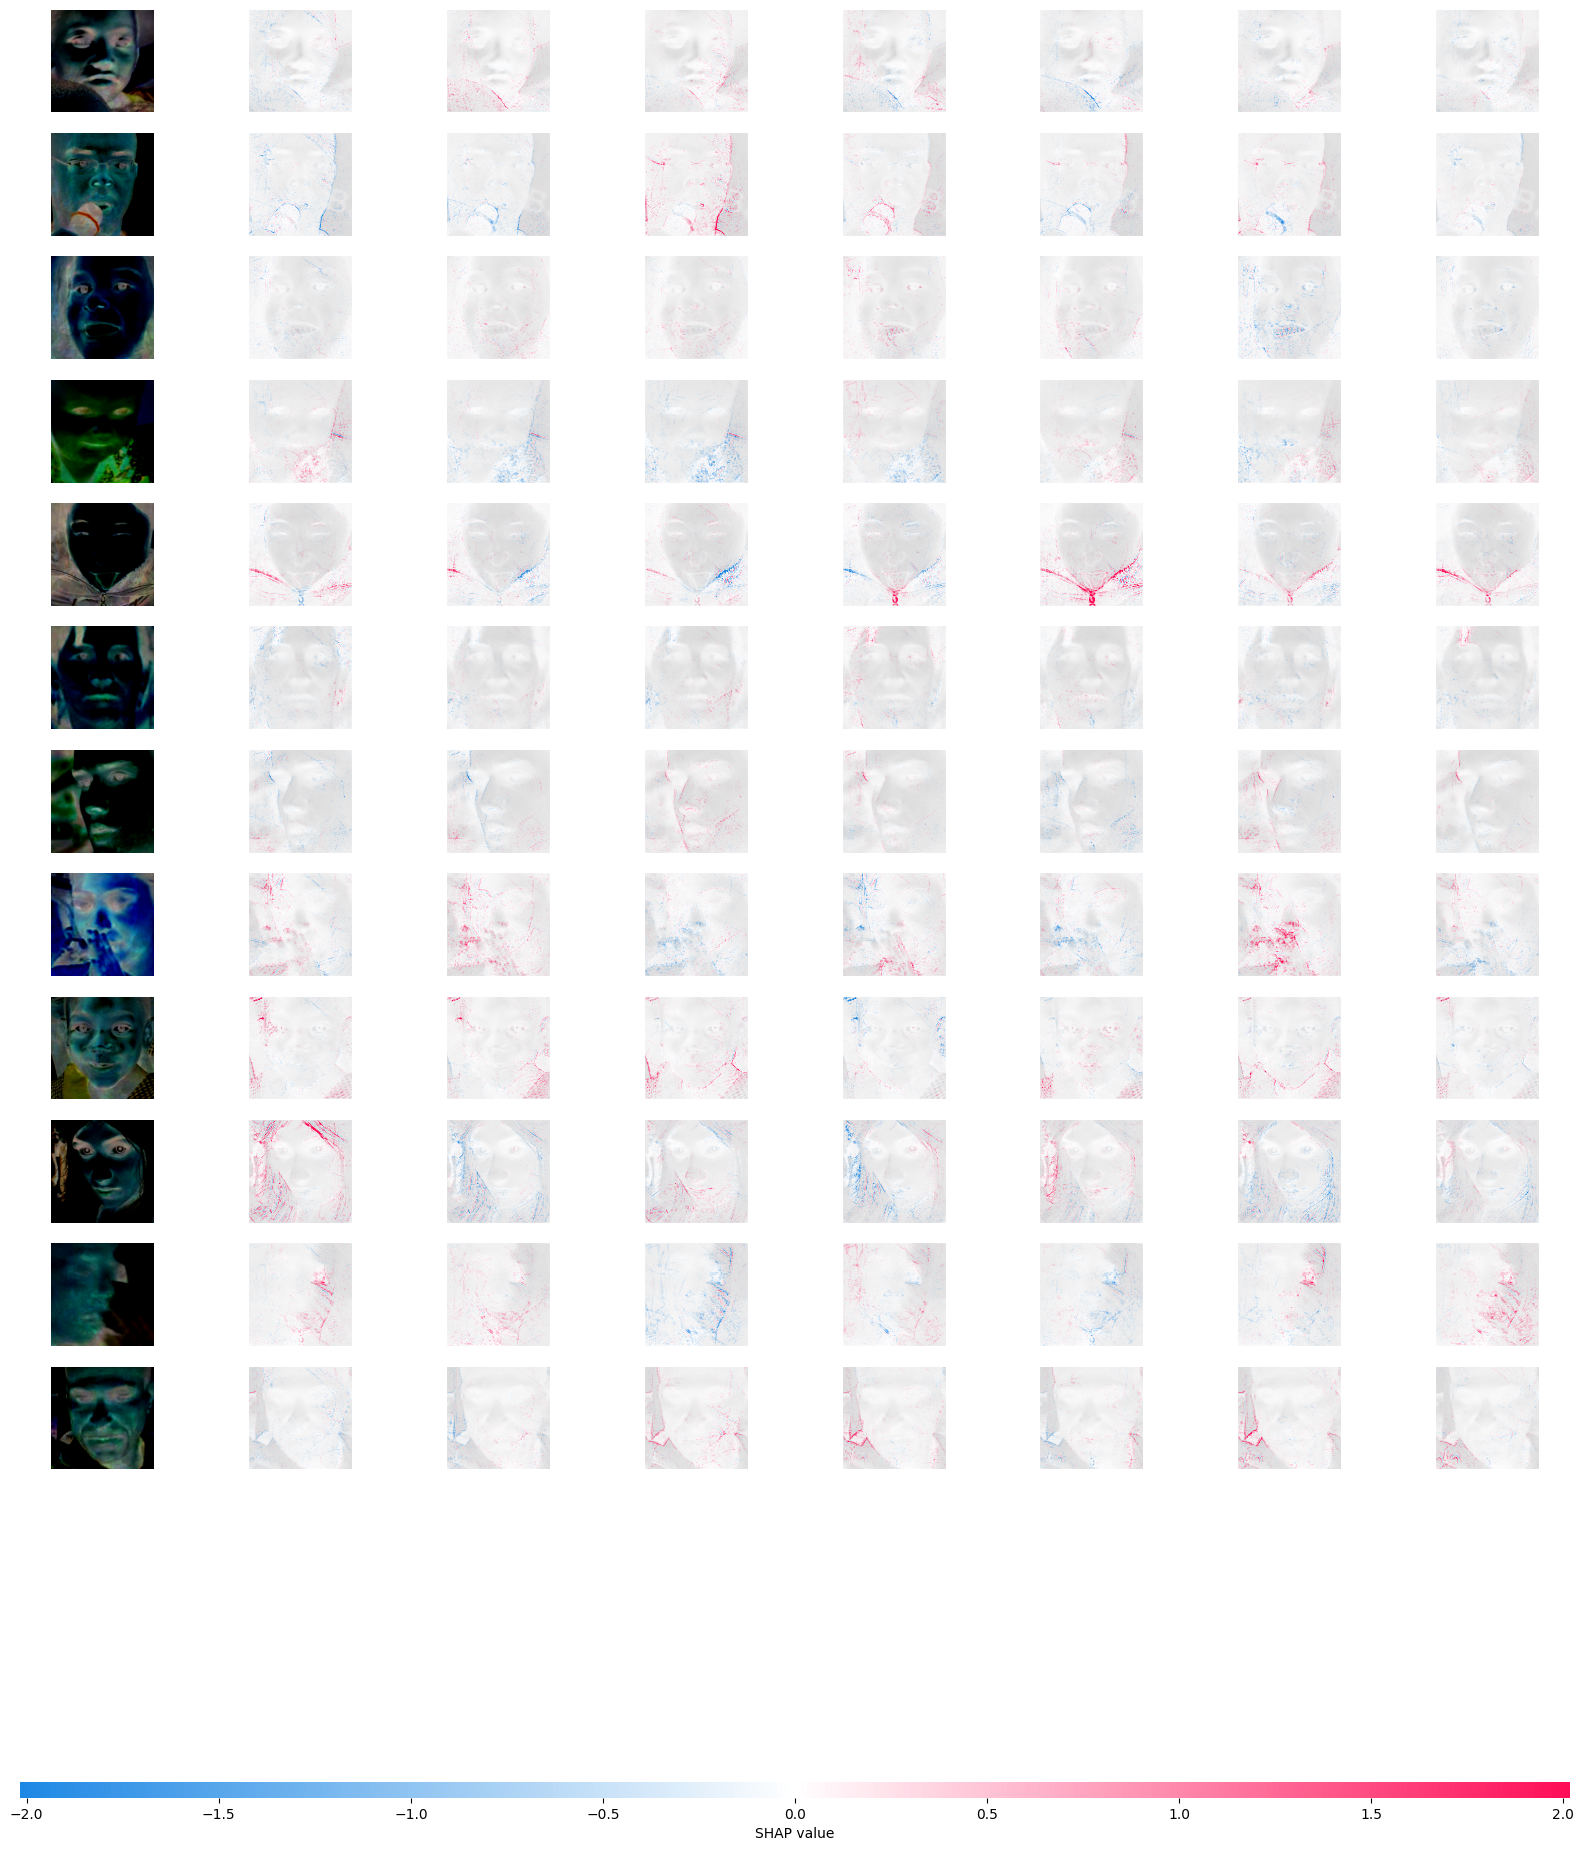

In [ ]:
shap.image_plot(shap_numpy, -test_numpy*225)

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
lbl

tensor([1, 2, 5, 3, 2, 6, 3, 3, 6, 0, 6, 1, 5, 2, 0, 0, 2, 1, 4, 2, 3, 3, 4, 2,
        4, 4, 6, 5, 6, 4, 2, 2])

In [ ]:
lbl[7:20]

tensor([3, 6, 0, 6, 1, 5, 2, 0, 0, 2, 1, 4, 2])

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(0, 1)).float()

In [ ]:
img1 =np.array(Image.open('./val_/Latino_Hispanic/1024.jpg'))
img2 = np.array( Image.open('./val_/Black/10081.jpg'))

In [ ]:
img1,img2 = img1/255, img2/255

In [ ]:
test_imgs =[img1, img2]

In [ ]:
to_explain =np.array([img1, img2])

In [ ]:
e = shap.GradientExplainer((model, model.features[7]), normalize(img1))

In [ ]:
imgs_test =[[img1, img2]] 

In [ ]:
imgs_test =np.array(imgs_test)

In [ ]:
imgs_test/255

TypeError: unsupported operand type(s) for /: 'JpegImageFile' and 'int'

In [ ]:
var_arr =np.array(var)

In [ ]:
var_arr = var_arr/255

In [ ]:
to_explain = var_arr

In [ ]:
class_names = class_map.keys()

In [ ]:
e = shap.GradientExplainer((model, model.features[7]), normalize(var_arr))

AxisError: axis2: axis 3 is out of bounds for array of dimension 3

In [ ]:
class_map = {'Latino_Hispanic': 0,
             'East Asian': 1,
             'Indian': 2,
             'Middle Eastern': 3,
             'Black': 4,
             'Southeast Asian': 5,
             'White': 6
             }

In [ ]:
test_images[0]

tensor([[[ 1.7009,  1.6838,  1.6838,  ...,  0.0227, -0.0801, -0.0972],
         [ 1.6495,  1.6495,  1.6667,  ..., -0.0458, -0.1314, -0.1486],
         [ 1.5810,  1.6153,  1.6667,  ..., -0.1314, -0.2171, -0.1999],
         ...,
         [-0.7137, -0.7993, -1.0048,  ..., -0.4739, -0.4739, -0.4739],
         [-0.6623, -0.7479, -0.9534,  ..., -0.4739, -0.4739, -0.4739],
         [-0.6623, -0.7137, -0.9363,  ..., -0.4739, -0.4739, -0.4739]],

        [[ 1.8333,  1.8158,  1.8158,  ...,  0.2052,  0.1527,  0.1352],
         [ 1.7808,  1.7808,  1.7983,  ...,  0.1352,  0.1001,  0.0826],
         [ 1.6933,  1.7283,  1.7808,  ...,  0.0476,  0.0126,  0.0301],
         ...,
         [-1.1779, -1.2304, -1.3704,  ..., -0.9853, -0.9853, -0.9853],
         [-1.1604, -1.1779, -1.3179,  ..., -0.9853, -0.9853, -0.9853],
         [-1.1604, -1.1779, -1.3004,  ..., -0.9853, -0.9853, -0.9853]],

        [[ 2.2391,  2.2217,  2.2217,  ...,  0.6879,  0.6531,  0.6356],
         [ 2.1868,  2.1868,  2.2043,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


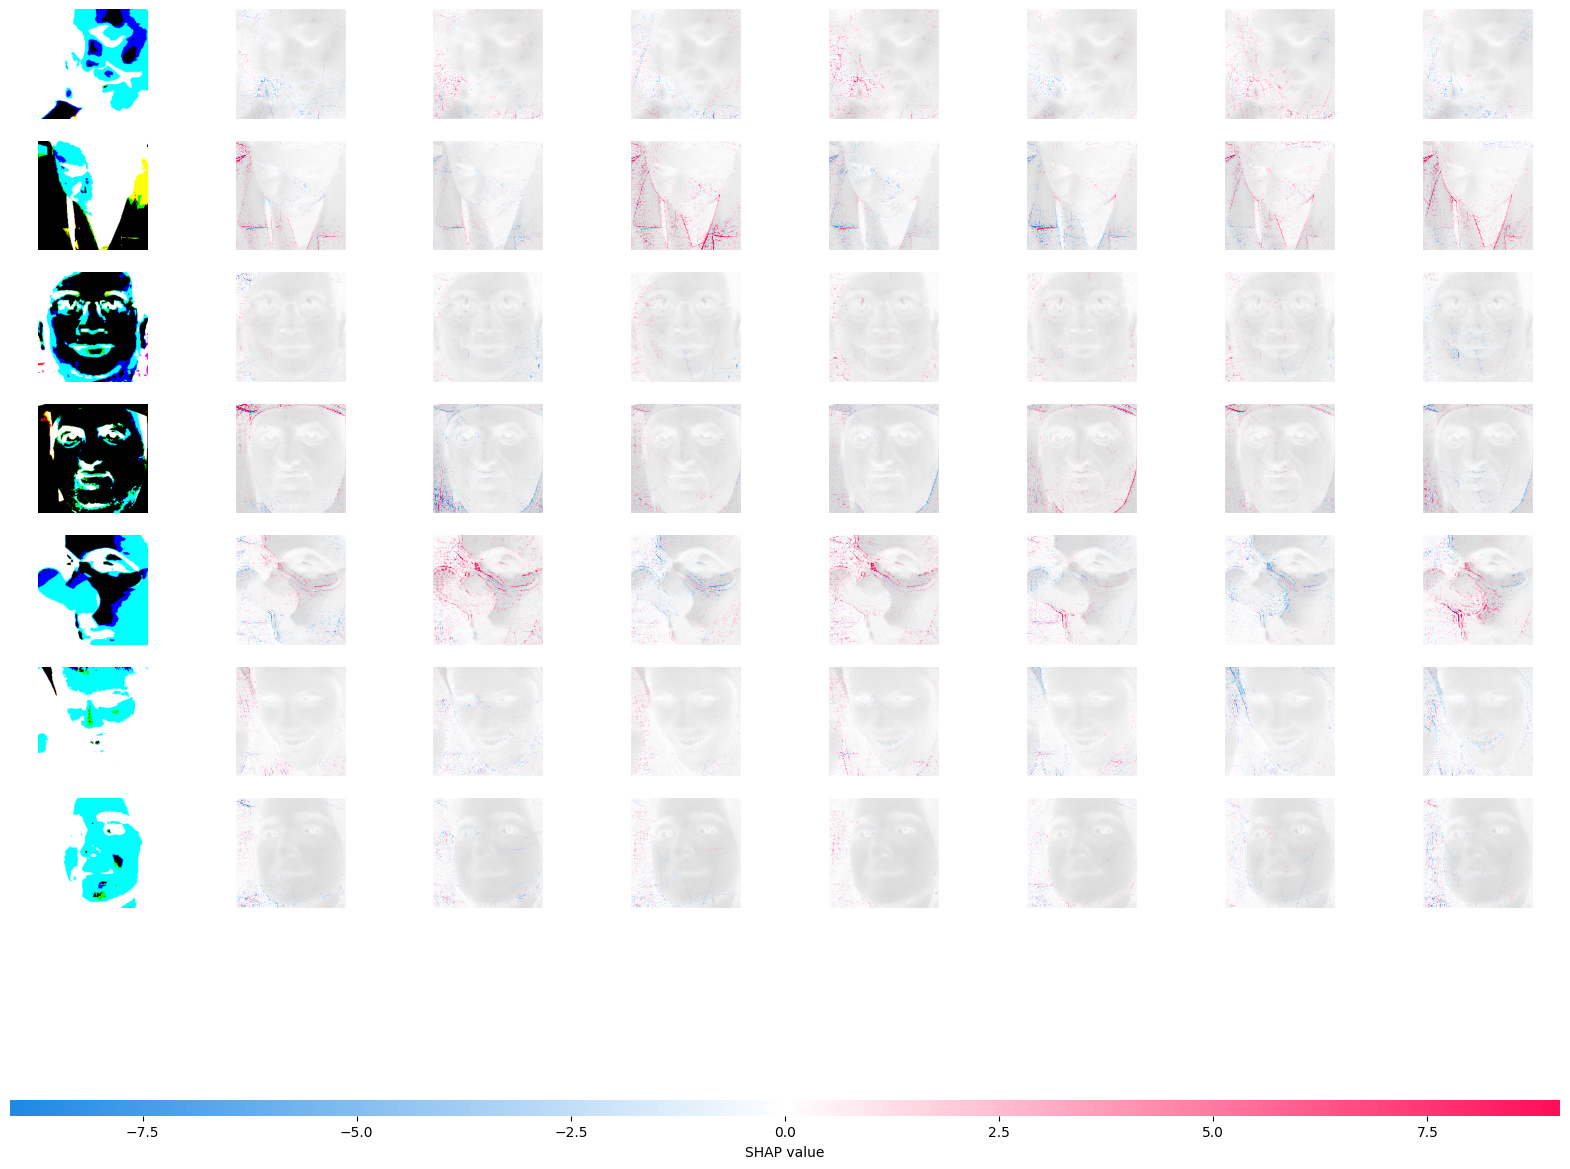

In [ ]:
batch = next(iter(test_loader))
images, _ = batch

background = images[8:20].to(device)
test_images = images[7:14].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy*2)

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
batch = next(iter(test_loader))

NameError: name 'test_loader' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


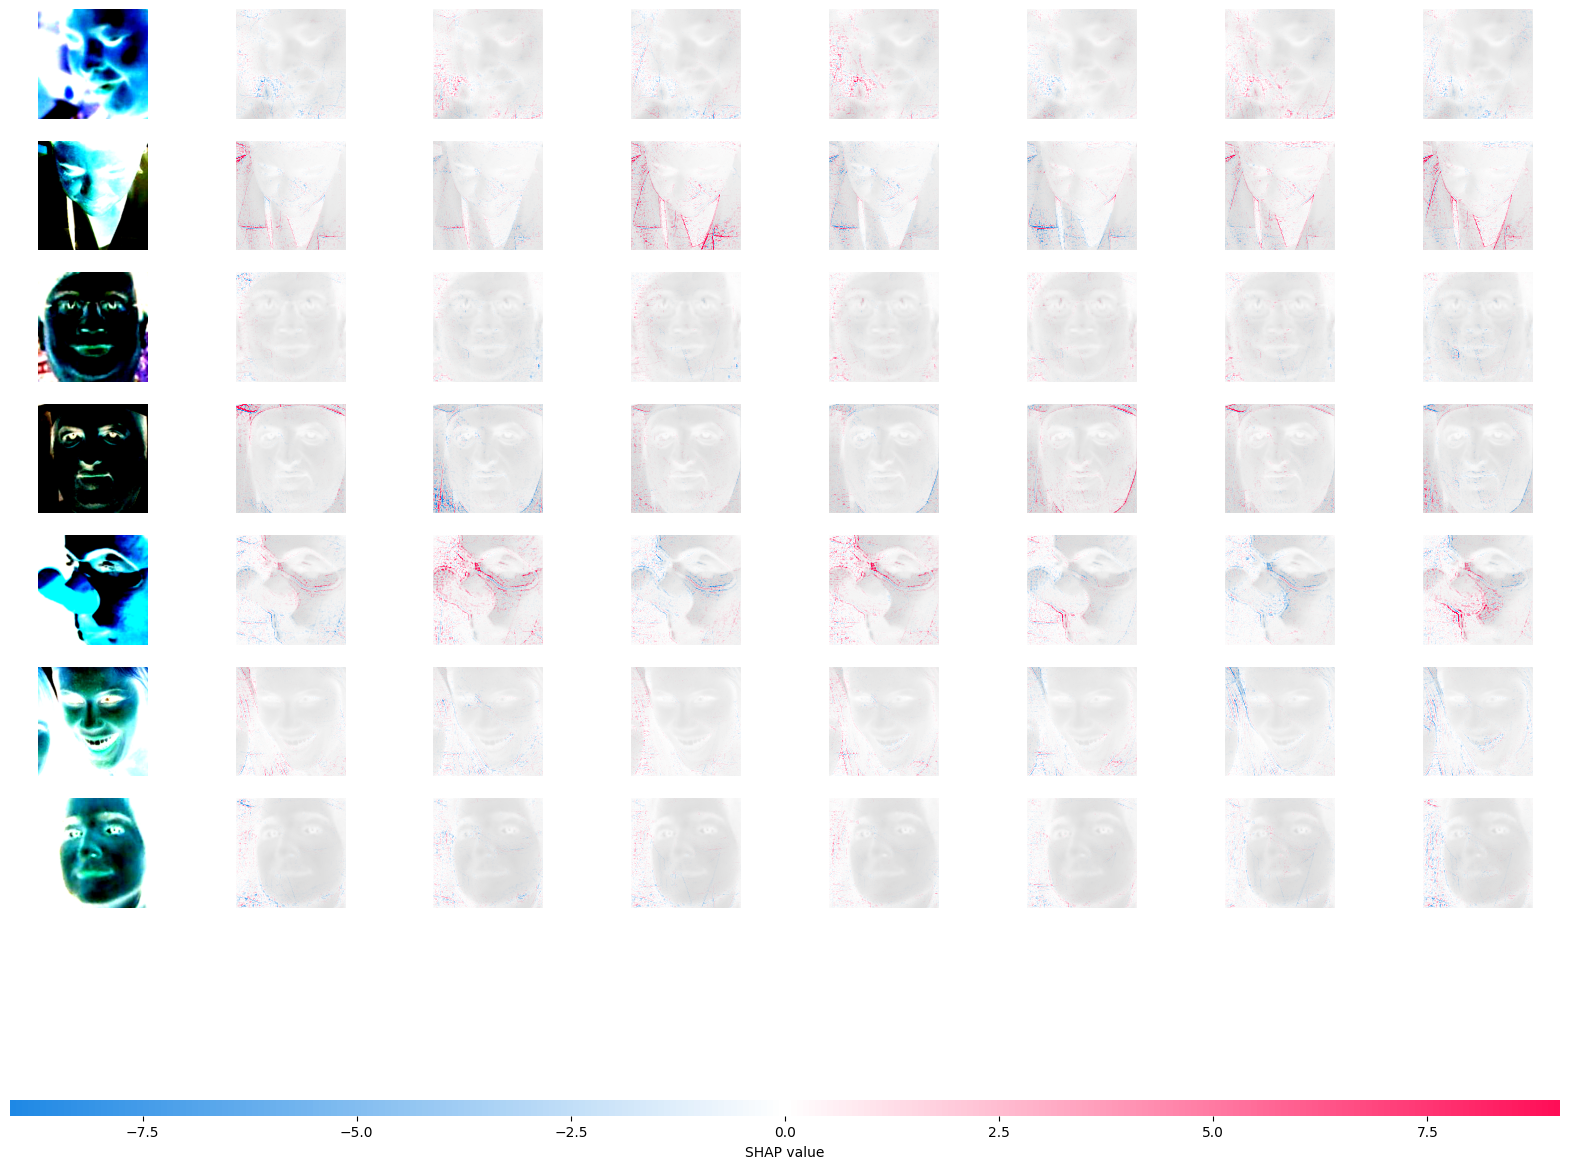

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)